In [2]:
import time
import datetime
from sys import maxsize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.linear_model import Lasso
from sklearn import preprocessing, svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from IPython.display import display, HTML

# Stochastic Gradient Optimization

In [128]:
"""
Sign of learningRate determines whether to use gradient ascent/descent:
Negative learningRates = descent, positive = ascent
"""
def SGO(x, y, seed, gradientFunc, learningRate, error, maxIter):
    x = np.array(x)
    y = np.array(y)

    # Reshape 1-D arrays to column format
    # if len(x.shape) == 1:
    #     x = x.reshape(-1, 1)

    N = len(x)
    currentError = maxsize
    lastError = 0
    beta = np.array(seed)
#     print('SGO weight shape:', beta.shape)
    i = 0

    while i < maxIter:
        gradient = gradientFunc(beta, x, y)
#         yPredicted = x.dot(beta)
#         sqErrGradient = np.array(np.dot(x.T, (yPredicted - y)) / N)
        beta += learningRate * gradient
#         currentError = np.sum(np.square(y - yPredicted)) / N
        currentError = np.sum(gradient)
#         print(currentError)

        if abs(lastError - currentError) < error:
            break
        lastError = currentError
        i += 1

    return beta

# SVM

In [178]:
class MySVM:
    def __init__(self, C, learningRate=1e-3, error=1e-2, maxIter=1000,
                 kernel='linear', method='primal'):
        if kernel == 'linear':
            self.kernel =  self._linearKernel
            
        self.method = method
        self.learningRate = learningRate
        self.error = error
        self.maxIter = maxIter
        self.C = C
        self.supportVectorIndices = []
    
    def fit(self, x, y):
        xCopy = self._removeIntercept(x)
        seed = np.zeros(len(x))
        self._grad = np.ndarray(shape=seed.shape, dtype=float)
        
        if self.method == 'primal':
            self.weights = SGO(xCopy, y, seed, self._svmPrimalGradient,
                               -self.learningRate, self.error, self.maxIter)
            
        else:
            self.alphas = SGO(xCopy, y, seed, self._svmDualGradient,
                    self.learningRate, self.error, self.maxIter)
            self.weights = np.sum(self.alphas * xCopy.T * y, axis=1)
    
    def predict(self, x):
        x = self._removeIntercept(x)
        return np.sign([self.weights.dot(xVal) for xVal in x])
    
    # Return (accuracy, precision, recall, F1) tuple
    def score(self, x, yGold):
        TPs = []
        TNs = []
        FPs = []
        FNs = []
        predictions = self.predict(x)
        correct = np.sum([1 for prediction, yVal in zip(predictions, yGold)
                       if prediction == yVal])
        
        for classVal in [-1, 1]:
            TP = TN = FP = FN = 0
            for i, truth in enumerate(yGold):
                prediction = predictions[i]
                if prediction == truth == classVal:
                    TP += 1
                elif prediction == truth and truth != classVal:
                    TN += 1
                elif prediction != truth and truth == classVal:
                    FN += 1
                else:
                    FP += 1
            TPs.append(TP)
            TNs.append(TN)
            FPs.append(FP)
            FNs.append(FN)
        
        print('TPs:', TPs)
        print('FPs:', FPs)
        print('TNs:', TNs)
        print('FNs:', FNs)
        accuracy = sum(TPs) / len(yGold)
        precision = sum(TPs) / (2 * (sum(TPs) + sum(FPs)))
        recall = sum(TPs) / (2 * (sum(TPs) + sum(FNs)))
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0
                 
        return accuracy, precision, recall, f1
    
    def _svmPrimalGradient(self, weights, x, y):
        self.supportVectorIndices = [i for i in range(len(x))
                                    if y[i] * x[i].T.dot(weights) < 1]
        signedSupportVecs = np.array([y[i] * x[i] for i in self.supportVectorIndices])
        return weights - self.C * np.sum(signedSupportVecs, axis=0) \
            - self.C * np.sum(y[i] for i in self.supportVectorIndices)
    
    def _svmDualGradient(self, weights, x, y):
        for i in range(len(weights)):
            self._grad[i] = 1.0 - y[i] * np.sum([weights[j] * y[j] * x[i].T.dot(x[j])
                                        for j in range(len(weights))])
            
        return self._grad
    
    def _removeIntercept(self, x):
        xCopy = np.array(x)
        
        if len(xCopy.shape) == 1:
            xCopy = xCopy.reshape(-1, 1)
        xCopy = np.insert(xCopy, 0, np.ones(x.shape[0]), axis=1)
        
        return xCopy
    
    def _linearKernel():
        pass

# Predicting Malignancy of Breast Cancer Cases
## Source: [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)

In [179]:
breastCancerDf = pd.read_csv('data/breast-cancer-wisconsin.csv')
breastCancerDf.loc[breastCancerDf['Class'] == 2, 'Class'] = 1
breastCancerDf.loc[breastCancerDf['Class'] == 4, 'Class'] = -1
# breastCancerDf.drop('BareNuclei', axis=1)
breastCancerDf.drop(breastCancerDf[breastCancerDf['BareNuclei'] == '?'].index, inplace=True)

yColumn = 'Class'
xColumns = [col for col in breastCancerDf.columns
            if col != 'ID' and col != yColumn
           and col != 'BareNuclei']
display(breastCancerDf[xColumns + [yColumn]].head())

print('% malignant', len(breastCancerDf['Class'].loc[breastCancerDf['Class'] == 1]) / len(breastCancerDf['Class']))

# Split into test and training sets
xTrain, xTest, yTrain, yTest = train_test_split(breastCancerDf[xColumns].as_matrix(),
                                               breastCancerDf[yColumn].as_matrix(),
                                               test_size=1/3, random_state=int(time.time()))
# np.random.seed(524)
# trainProportion = 0.8
# trainMask = np.random.rand(len(breastCancerDf)) < trainProportion
# cancerTrainingDf = breastCancerDf[trainMask]
# cancerTestDf = breastCancerDf[~trainMask].reset_index()
# print('Total # cancer samples: {}, training samples: {}, test samples: {}'.format(
#     len(breastCancerDf), len(cancerTrainingDf), len(cancerTestDf)))

,ClumpThickness,CellSizeUniformity,CellShapeUniformity,MarginalAdhesion,SingleEpithelialCellSize,BlandChromatin,NormalNucleoli,Mitoses,Class
0,5,1,1,1,2,3,1,1,1
1,5,4,4,5,7,3,2,1,1
2,3,1,1,1,2,3,1,1,1
3,6,8,8,1,3,3,7,1,1
4,4,1,1,3,2,3,1,1,1


% malignant 0.6500732064421669


In [182]:
classifier = MySVM(C=1, learningRate=3e-6, error=1e-3, method='dual', maxIter=100)
classifier.fit(xTrain, yTrain)
print('Weights:', classifier.weights)
supportVecs = classifier.supportVectorIndices
print('Support vectors len={}: {}'.format(len(supportVecs), supportVecs))
print('xTest:', xTest)
accuracy, precision, recall, f1 = classifier.score(xTest, yTest)
print('Accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}, F1: {:.4f}'.format(
        accuracy, precision, recall, f1))

Weights: [ 0.05623519  0.03869296 -0.05272685 -0.04963241 -0.03495176  0.03593554
  0.01195445 -0.04072515  0.01972926]
Support vectors len=0: []
xTest: [[10  3  5 ...,  3 10  2]
 [10  8 10 ...,  5  1  1]
 [ 3  1  1 ...,  3  2  1]
 ..., 
 [ 3  3  2 ...,  3  6  1]
 [ 6  3  2 ...,  4  1  1]
 [ 1  1  1 ...,  2  1  1]]
TPs: [63, 131]
FPs: [29, 5]
TNs: [131, 63]
FNs: [5, 29]
Accuracy: 0.8509, precision: 0.4254, recall: 0.4254, F1: 0.4254


## Sklearn Linear SVC for Comparison

In [7]:
testSVM = svm.SVC(kernel='linear')
testSVM.fit(xTrain, yTrain)
print('Coefficients: {}, beta: {}'.format(testSVM.coef_, testSVM.intercept_))
print('Support vectors len={}: {}'.format(len(testSVM.support_), testSVM.support_))
scores = cross_val_score(testSVM, breastCancerDf[xColumns].as_matrix(),
                        breastCancerDf[yColumn].as_matrix(),
                        cv=5)
predicted = testSVM.predict(xTest)
precision, recall, f1, support = precision_recall_fscore_support(yTest, predicted,
                                                                average='binary')
print('Sklearn SVM Accuracy:', scores.mean())
print('Precision={}, recall={}, F1={}'.format(precision, recall, f1))

Coefficients: [[-0.21100351 -0.12912066 -0.20803808 -0.17090812 -0.15630253 -0.258747
  -0.0582106  -0.29634623]], beta: [ 4.71956438]
Support vectors len=37: [ 30  63  71 105 123 154 196 221 228 278 287 308 323 345 374 401 437  23
  35  42  59  79 131 141 144 146 200 202 208 216 240 249 261 267 283 313
 398]
Sklearn SVM Accuracy: 0.964898621249
Precision=0.9726027397260274, recall=0.9726027397260274, F1=0.9726027397260274


# HR Employee Dataset - Predicting whether or not employees will leave
### Source: Kaggle https://www.kaggle.com/ludobenistant/hr-analytics

In [8]:
hrDf = pd.read_csv('data/HR_comma_sep.csv', sep=',').sample(frac=0.1)
# hrDf.loc[hrDf['last_evaluation'], 'last_evaluation'] = 
hrDf['last_evaluation'] *= 100
hrDf['satisfaction_level'] *= 100
hrDf.loc[hrDf['left'] == 1, 'left'] = 1
hrDf.loc[hrDf['left'] == 0, 'left'] = -1
# display(hrDf.head())
# encoder = OneHotEncoder()
# print(hrDf['sales'])
# encoder.fit(hrDf['sales'])
# hrDf['encodedSales'] = encoder.transform(hrDf['sales'])
# display(hrDf.head())
categoricalColumns = ['sales', 'salary']
print('Columns:', hrDf.columns)
hrDf = pd.get_dummies(hrDf, 'enc', columns=categoricalColumns)
display(hrDf.head())

msk = np.random.rand(len(hrDf)) < 0.8
x, y = hrDf.drop('left', axis=1), hrDf['left']
xTrain, xTest = x[msk].as_matrix(), x[~msk].as_matrix()
yTrain, yTest = y[msk].as_matrix(), y[~msk].as_matrix()

Columns: Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,enc_IT,enc_RandD,...,enc_hr,enc_management,enc_marketing,enc_product_mng,enc_sales,enc_support,enc_technical,enc_high,enc_low,enc_medium
14297,17.0,84.0,5,232,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
9768,76.0,81.0,3,175,3,0,-1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
5725,57.0,61.0,5,254,5,0,-1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
5350,45.0,72.0,4,149,3,0,-1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
564,41.0,53.0,2,157,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Sklearn SVC

In [9]:
kernel = 'linear'
testSVM = svm.SVC(kernel=kernel)
testSVM.fit(xTrain, yTrain)
predicted = testSVM.predict(xTest)
precision, recall, f1, support = precision_recall_fscore_support(yTest, predicted,
                                                                average='binary')
print('Sklearn accuracy:', testSVM.score(xTest, yTest))
print('Precision={:.4f}, recall={:.4f}, f1={:.4f}'.format(precision, recall, f1))

Sklearn accuracy: 0.808724832215
Precision=0.5143, recall=0.3103, f1=0.3871


## My SVM

In [84]:
learnRate = 1e-4
classifier = MySVM(C=1, learningRate=learnRate, method='dual')
classifier.fit(xTrain, yTrain)
accuracy, precision, recall, f1 = classifier.score(xTest, yTest)
print('Accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}, F1: {:.4f}'.format(
        accuracy, precision, recall, f1))

Starting weights: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. 

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:90: RuntimeWarning: overflow encountered in double_scalars
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in add


IndexError: index 2 is out of bounds for axis 0 with size 1

# Predicting Doctor Visit No Shows
## Source: Kaggle: https://www.kaggle.com/joniarroba/noshowappointments

In [23]:
def convertTime(timeStr):
    return time.mktime(datetime.datetime.strptime(timeStr, '%Y-%m-%dT%H:%M:%SZ').timetuple())

noShows = pd.read_csv('data/No-show-Issue-Comma-300k.csv',
                     converters={'AppointmentRegistration': convertTime,
                                'ApointmentData': convertTime}).sample(n=300)
print('Number of no show samples:', len(noShows))
noShows.rename(columns={'ApointmentData': 'AppointmentDate', 'Alcoolism': 'Alcoholism'}, inplace=True)
noShows.loc[noShows['Status'] == 'Show-Up', 'Status'] = 1
noShows.loc[noShows['Status'] == 'No-Show', 'Status'] = -1
noShows['Status'] = noShows['Status'].astype(int)
noShows['AptRegistrationDifference'] = noShows.AppointmentDate - noShows.AppointmentRegistration
display(noShows.head())
print(noShows.Status.unique())
print(noShows.columns)

mask = np.random.rand(len(noShows)) < 0.8
xCols = ['Age', 'AptRegistrationDifference']

train, test = noShows[mask], noShows[~mask]
xTrain, xTest = train[xCols], test[xCols]
yTrain, yTest = train['Status'], test['Status']

Number of no show samples: 300


,Age,Gender,AppointmentRegistration,AppointmentDate,DayOfTheWeek,Status,Diabetes,Alcoholism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime,AptRegistrationDifference
267815,43,F,1.413295e+09,1.416182e+09,Monday,1,0,0,0,0,0,0,0,0,-34,2887895.0
218275,73,M,1.431017e+09,1.431562e+09,Thursday,1,0,0,0,0,0,0,0,1,-7,544432.0
204744,53,F,1.401190e+09,1.401322e+09,Thursday,1,0,0,1,0,0,0,0,0,-2,131696.0
241883,20,F,1.443783e+09,1.444003e+09,Monday,1,0,0,0,0,0,0,0,1,-3,219907.0
293293,13,F,1.391514e+09,1.392768e+09,Wednesday,1,0,0,0,0,0,0,0,0,-15,1253640.0


[ 1 -1]
Index(['Age', 'Gender', 'AppointmentRegistration', 'AppointmentDate',
       'DayOfTheWeek', 'Status', 'Diabetes', 'Alcoholism', 'HiperTension',
       'Handcap', 'Smokes', 'Scholarship', 'Tuberculosis', 'Sms_Reminder',
       'AwaitingTime', 'AptRegistrationDifference'],
      dtype='object')


## Sklearn SVM

In [ ]:
kernel = 'linear'
print('xTrain:', len(xTrain))
testSVM = svm.SVC(kernel=kernel)
testSVM.fit(xTrain.values, yTrain.values)
predicted = testSVM.predict(xTest.values)
precision, recall, f1, support = precision_recall_fscore_support(yTest.values, predicted,
                                                                average='binary')
print('Sklearn accuracy:', testSVM.score(xTest.values, yTest.values))
print('Precision={:.4f}, recall={:.4f}, f1={:.4f}'.format(precision, recall, f1))

           Age_Z  AptRegistrationDifference_Z
267815  0.295988                     0.949796
218275  1.644792                    -0.377821
204744  0.745589                    -0.611644
241883 -0.738096                    -0.561671
293293 -1.052817                     0.023959
116739  0.745589                     0.364016
277396  0.340948                    -0.654322
137232  0.026227                    -0.508148
142001  0.835509                    -0.414510
30781   0.430868                     0.521130


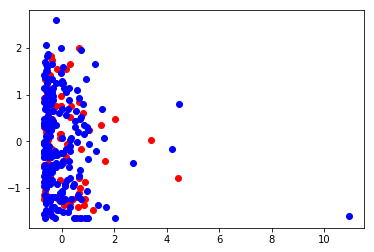

In [31]:
def getColor(status):
    if status == -1:
        return (1.0, 0.0, 0.0)
    else:
        return (0.0, 0.0, 1.0)
    
noShows['Age_Z'] = (noShows.Age - noShows.Age.mean()) / noShows.Age.std(ddof=0)
noShows['AptRegistrationDifference_Z'] = (noShows.AptRegistrationDifference - noShows.AptRegistrationDifference.mean()) \
    / noShows.AptRegistrationDifference.std(ddof=0)

standardXCols = ['Age_Z', 'AptRegistrationDifference_Z']
print(noShows[['Age_Z', 'AptRegistrationDifference_Z']][:10])
noShowVals = noShows.loc[noShows['Status'] == -1][standardXCols]
showVals = noShows.loc[noShows['Status'] == 1][standardXCols]
noShows['Color'] = noShows['Status'].apply(getColor)
# print(noShows['Color'])
# print(noShowVals[:10])

plt.plot(noShowVals['AptRegistrationDifference_Z'], noShowVals['Age_Z'], 'ro',
        showVals['AptRegistrationDifference_Z'], showVals['Age_Z'], 'bo')
plt.show()